In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt


import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

In [2]:
# Loading Dataset

df=pd.read_csv('../input/delhi-weather-data/testset.csv')

print(df.columns)

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm'],
      dtype='object')


In [3]:
df.head()

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0


In [4]:
total = df.isnull().sum().sort_values(ascending=False)
percent_1 = df.isnull().sum()/df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
_precipm,100990,100.0
_windchillm,100411,99.4
_wgustm,99918,98.9
_heatindexm,71835,71.1
_wdire,14755,14.6


In [5]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
df.set_index('datetime_utc', inplace= True)
df =df.resample('D').mean()

In [6]:
df=df.iloc[:,[9]]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7480 entries, 1996-11-01 to 2017-04-24
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0    _tempm  7336 non-null   float64
dtypes: float64(1)
memory usage: 116.9 KB


In [8]:
from scipy.interpolate import interp1d

In [9]:
# we will fill the null row
df = df.iloc[:,[0]].interpolate()

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7480 entries, 1996-11-01 to 2017-04-24
Freq: D
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0    _tempm  7480 non-null   float64
dtypes: float64(1)
memory usage: 116.9 KB


In [11]:
df.head()

,_tempm
datetime_utc,
1996-11-01,22.333333
1996-11-02,22.916667
1996-11-03,21.791667
1996-11-04,22.722222
1996-11-05,27.800000


q1

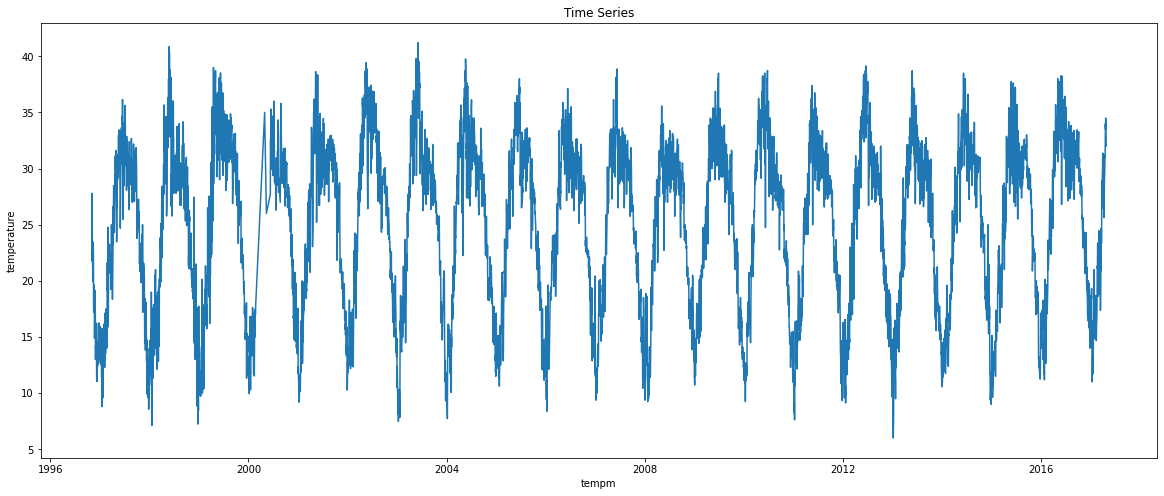

In [12]:
plt.figure(figsize=(20,8))
plt.plot(df)
plt.title('Time Series')
plt.xlabel('tempm')
plt.ylabel('temperature')
plt.show()

In [13]:
data=df.values
data=df.astype('float32')

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(-1,1))
sc = scaler.fit_transform(data)

In [15]:
timestep = 30

X= []
Y=[]


for i in range(len(sc)- (timestep)):
    X.append(sc[i:i+timestep])
    Y.append(sc[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)


k = 7300
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:]

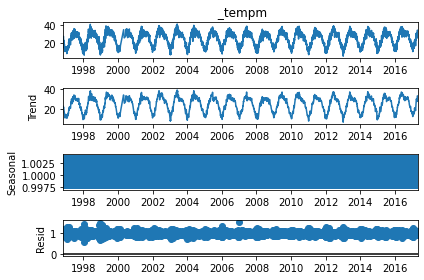

In [16]:
decomposition = sm.tsa.seasonal_decompose(data.iloc[:,0], model='multiplicative')
fig = decomposition.plot()
plt.show()

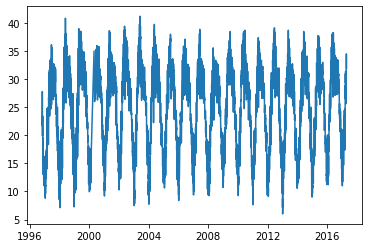

In [17]:
plt.plot(data.iloc[:,0])

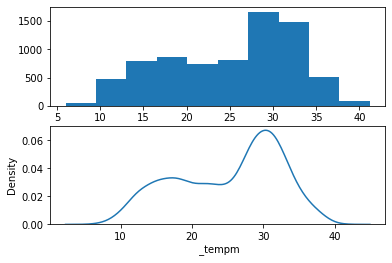

In [18]:
plt.figure(1)  # CHECK THE DISTRIBUTION
plt.subplot(211)
plt.hist(data.iloc[:,0])
plt.subplot(212)
sns.kdeplot(data.iloc[:,0])
plt.show()      # DATA IS LEFT SHIFTED

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='datetime_utc', ylabel=' _tempm'>

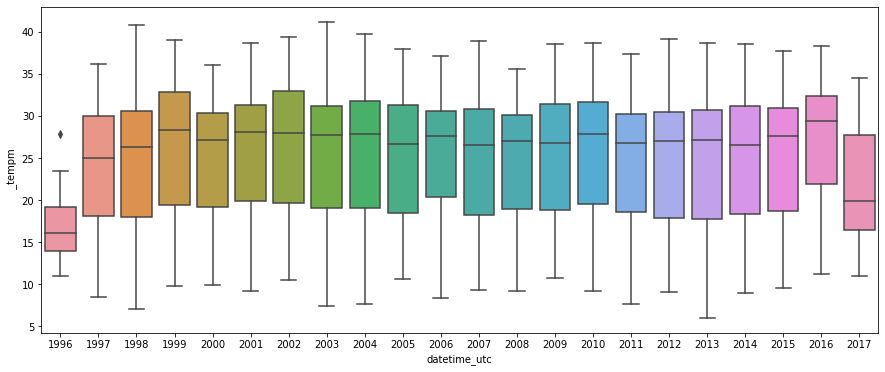

In [19]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(data.iloc[:,0].index.year, data.iloc[:,0], ax=ax)

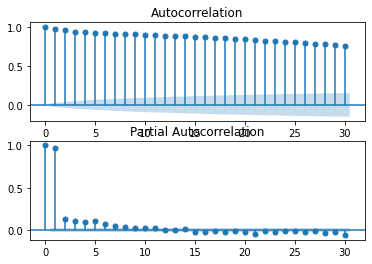

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()  # ACF PACF PLOTS
plt.subplot(211)
plot_acf(data.iloc[:,0], ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(data.iloc[:,0], ax=plt.gca(), lags = 30)
plt.show()

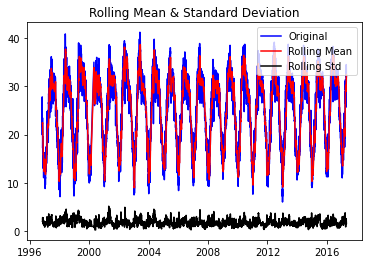

In [21]:
#Determing rolling statistics
rolmean = data.rolling(12).mean()
rolstd = data.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(data, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [22]:
from statsmodels.tsa.stattools import adfuller
#H0:IT IS NON STATIONARY
#H1:IT IS  STATIONARY

#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(data.iloc[:,0])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -7.455660e+00
p-value                        5.521250e-11
#Lags Used                     3.600000e+01
Number of Observations Used    7.443000e+03
Critical Value (1%)           -3.431229e+00
Critical Value (5%)           -2.861928e+00
Critical Value (10%)          -2.566977e+00
dtype: float64


In [23]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

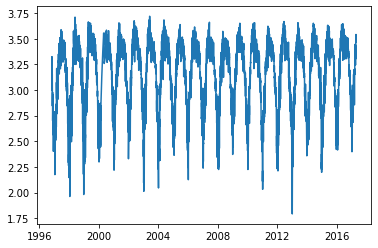

In [24]:
ts_log = np.log(data)
plt.plot(ts_log)

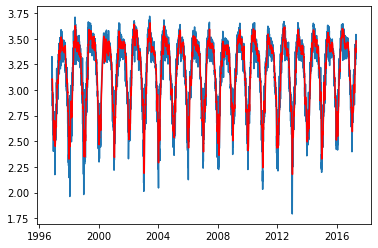

In [25]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [26]:
ts_log_moving_avg_diff = ts_log.iloc[:,0] - moving_avg.iloc[:,0]
ts_log_moving_avg_diff.head(12)

datetime_utc
1996-11-01         NaN
1996-11-02         NaN
1996-11-03         NaN
1996-11-04         NaN
1996-11-05         NaN
1996-11-06         NaN
1996-11-07         NaN
1996-11-08         NaN
1996-11-09         NaN
1996-11-10         NaN
1996-11-11         NaN
1996-11-12    0.050882
Freq: D, Name:  _tempm, dtype: float64

In [27]:
ts_log_moving_avg_diff.dropna(inplace=True)


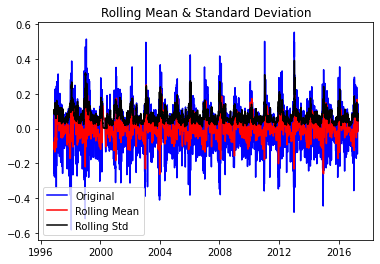

Results of Dickey-Fuller Test:
Test Statistic                -9.562017e+00
p-value                        2.411762e-16
#Lags Used                     3.600000e+01
Number of Observations Used    7.432000e+03
Critical Value (1%)           -3.431230e+00
Critical Value (5%)           -2.861929e+00
Critical Value (10%)          -2.566977e+00
dtype: float64


In [28]:
test_stationarity(ts_log_moving_avg_diff)

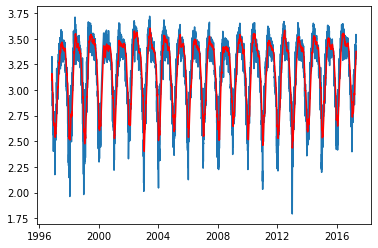

In [29]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

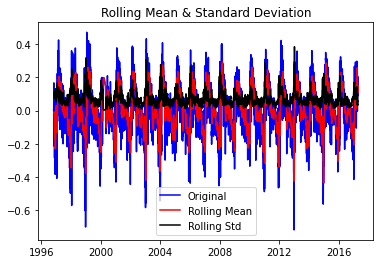

Results of Dickey-Fuller Test:
Test Statistic                -7.767979e+00
p-value                        9.079857e-12
#Lags Used                     2.900000e+01
Number of Observations Used    7.450000e+03
Critical Value (1%)           -3.431228e+00
Critical Value (5%)           -2.861928e+00
Critical Value (10%)          -2.566977e+00
dtype: float64


In [30]:
ts_log_ewma_diff = ts_log.iloc[:,0] - expwighted_avg.iloc[:,0]
test_stationarity(ts_log_ewma_diff)

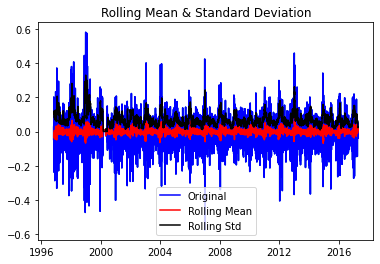

Results of Dickey-Fuller Test:
Test Statistic                -1.161445e+01
p-value                        2.468114e-21
#Lags Used                     3.600000e+01
Number of Observations Used    7.442000e+03
Critical Value (1%)           -3.431229e+00
Critical Value (5%)           -2.861928e+00
Critical Value (10%)          -2.566977e+00
dtype: float64


In [31]:
ts_log_diff = ts_log.iloc[:,0] - ts_log.iloc[:,0].shift(1)
plt.plot(ts_log_diff)
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)                           #stationary  series

q2

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


Text(0.5, 1.0, 'Autocorrelation Function')

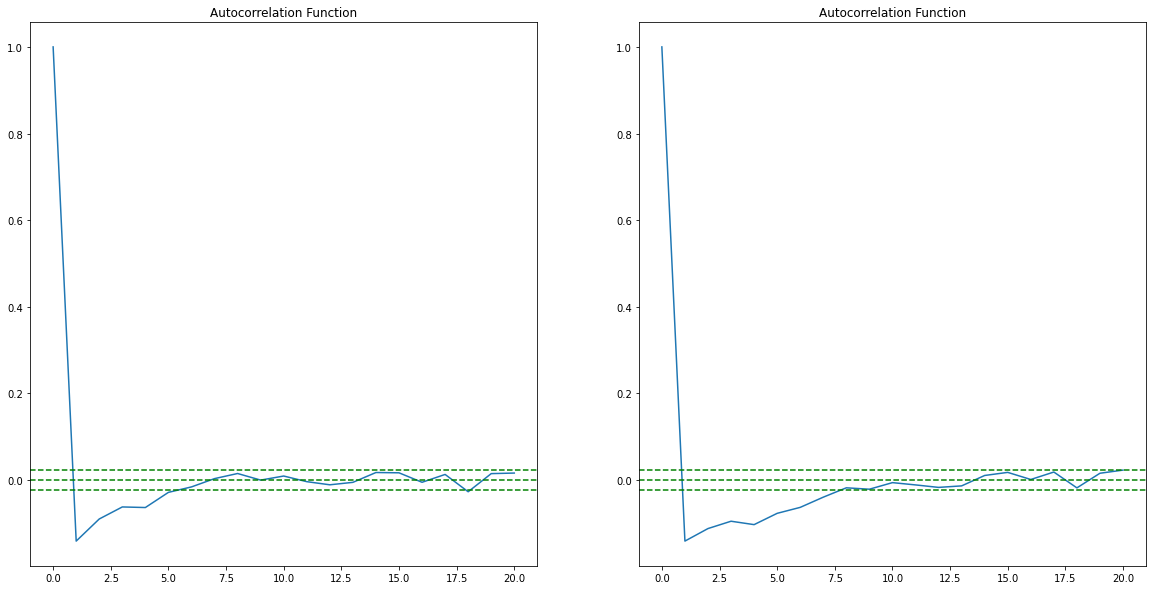

In [32]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf=acf(ts_log_diff, nlags=20)
lag_pacf=pacf(ts_log_diff, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

q3

In [33]:
def evaluate_forecast(data,pred):
    results = pd.DataFrame({'r2_score':r2_score(data, pred)}, index=[0])
    
    results['mean_absolute_error'] = mean_absolute_error(data, pred)
    results['median_absolute_error'] = median_absolute_error(data, pred)
    results['mse'] = mean_squared_error(data, pred)
    results['msle'] = mean_squared_log_error(data, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.14410D+00    |proj g|=  1.28344D-02

At iterate    1    f= -1.14410D+00    |proj g|=  4.01545D-04


 This problem is unconstrained.



At iterate    2    f= -1.14410D+00    |proj g|=  3.42735D-03

At iterate    3    f= -1.14410D+00    |proj g|=  5.76741D-03

At iterate    4    f= -1.14410D+00    |proj g|=  6.30609D-03

At iterate    5    f= -1.14411D+00    |proj g|=  2.37903D-02

At iterate    6    f= -1.14411D+00    |proj g|=  3.17593D-02

At iterate    7    f= -1.14411D+00    |proj g|=  1.87435D-02

At iterate    8    f= -1.14411D+00    |proj g|=  4.06137D-03

At iterate    9    f= -1.14411D+00    |proj g|=  6.23146D-04

At iterate   10    f= -1.14411D+00    |proj g|=  6.20037D-04

At iterate   11    f= -1.14411D+00    |proj g|=  9.98934D-04

At iterate   12    f= -1.14411D+00    |proj g|=  2.38256D-03

At iterate   13    f= -1.14411D+00    |proj g|=  4.06346D-03

At iterate   14    f= -1.14411D+00    |proj g|=  6.51645D-03

At iterate   15    f= -1.14411D+00    |proj g|=  1.25664D-02

At iterate   16    f= -1.14411D+00    |proj g|=  8.76661D-03

At iterate   17    f= -1.14412D+00    |proj g|=  9.80362D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


plotting ARIMA model


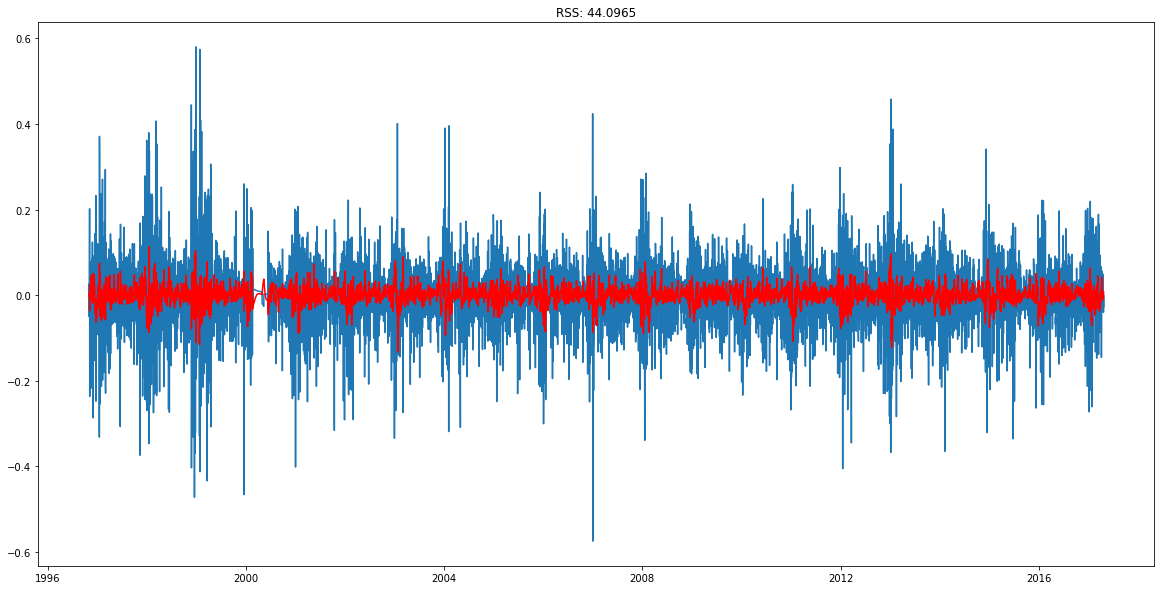

In [34]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(20,10))
model=ARIMA(ts_log , order=(2,1,2))  #log transformation
results=model.fit(disp=1)
plt.plot(ts_log_diff)
plt.plot(results.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results.fittedvalues-ts_log_diff)**2))
print('plotting ARIMA model')

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D. _tempm   No. Observations:                 7479
Model:                 ARIMA(2, 1, 2)   Log Likelihood                8584.518
Method:                       css-mle   S.D. of innovations              0.077
Date:                Mon, 17 Jan 2022   AIC                         -17157.037
Time:                        09:17:33   BIC                         -17115.518
Sample:                    11-02-1996   HQIC                        -17142.778
                         - 04-24-2017                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.545e-05      0.001      0.033      0.974      -0.001       0.002
ar.L1.D. _tempm     1.6873      0.019     86.658      0.000       1.649       1.725
ar.L2.D. _tempm    -0.6953      0.019    -36.739      0.000      -0.732      -0.658
ma.L1.D. _tempm    -1.8834      0.013   -143.083      0.000      -1.909      -1.858
ma.L2.D. _tempm     0.8904      0.013     69.426      0.000       0.865       0.916
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0290           +0.0000j            1.0290            0.0000
AR.2            1.3976           +0.0000j            1.3976            0.0000
MA.1            1.0576           -0.0674j            1.0597           -0.0101
MA.2            1.0576           +0.0674j            1.0597            0.0101
-----------------------------------------------------------------------------
"""

In [36]:
predictions=pd.Series(results.fittedvalues, copy=True)
print(predictions.head())

datetime_utc
1996-11-02    0.000025
1996-11-03   -0.003440
1996-11-04    0.004641
1996-11-05   -0.002728
1996-11-06   -0.036407
Freq: D, dtype: float64


In [37]:
predictions_cum_sum=predictions.cumsum()
print(predictions_cum_sum.head())

datetime_utc
1996-11-02    0.000025
1996-11-03   -0.003415
1996-11-04    0.001226
1996-11-05   -0.001502
1996-11-06   -0.037909
Freq: D, dtype: float64


In [38]:
predictions_log=pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_log=predictions_log.add(predictions_cum_sum,fill_value=0)
predictions_log.head()

datetime_utc
1996-11-01         NaN
1996-11-02    0.000025
1996-11-03   -0.003415
1996-11-04    0.001226
1996-11-05   -0.001502
Freq: D, dtype: float64

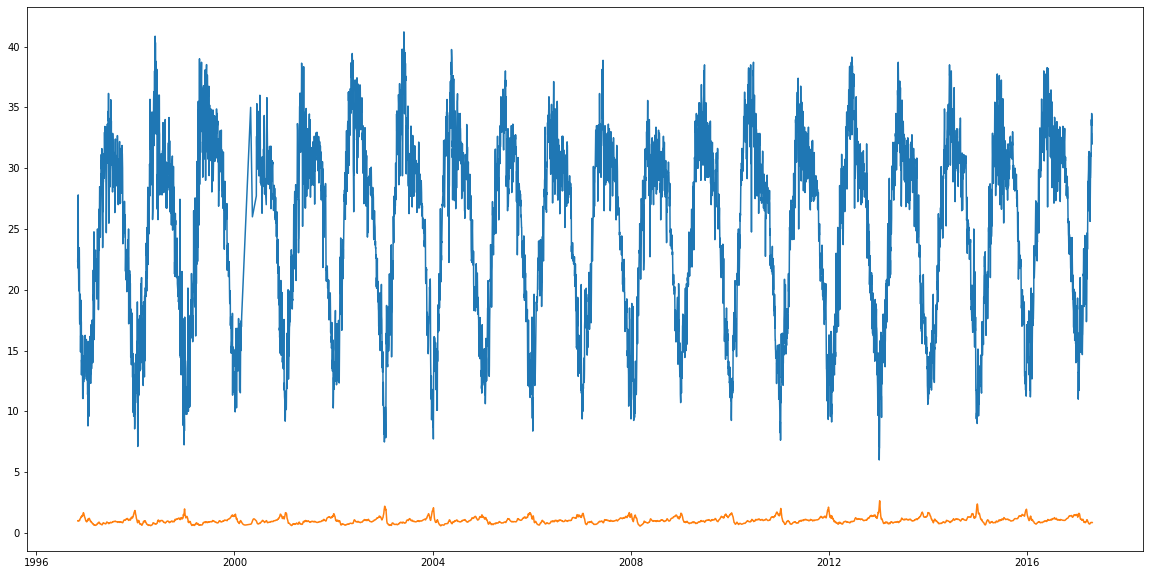

In [39]:
predictions_ARIMA=np.exp(predictions_log)
plt.figure(figsize=(20,10))
plt.plot(data)
plt.plot(predictions_ARIMA)

q5

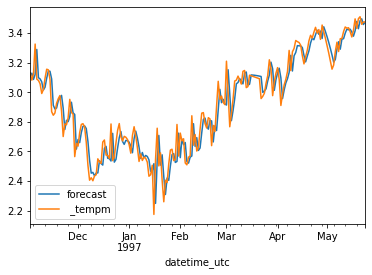

In [40]:
results.plot_predict(1,204)    #144 + 12*5
x=results.forecast(steps=140)  # SAVE IN AN ARRAY

q4

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.12830D+00    |proj g|=  6.05827D-04

At iterate    1    f= -1.12830D+00    |proj g|=  1.15463D-05

At iterate    2    f= -1.12830D+00    |proj g|=  3.61267D-05

At iterate    3    f= -1.12830D+00    |proj g|=  1.09979D-04

At iterate    4    f= -1.12830D+00    |proj g|=  5.39346D-05

At iterate    5    f= -1.12830D+00    |proj g|=  6.95000D-06

At iterate    6    f= -1.12830D+00    |proj g|=  8.65974D-07

At iterate    7    f= -1.12830D+00    |proj g|=  8.21565D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

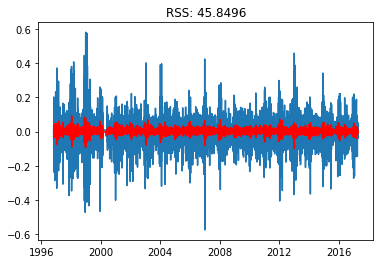

In [41]:
model1=ARIMA(ts_log , order=(2,1,0))#AR MODEL
results1=model1.fit(disp=1)
plt.plot(ts_log_diff)
plt.plot(results1.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results1.fittedvalues-ts_log_diff)**2))
print('plotting AR model')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13495D+00    |proj g|=  6.98552D-05

At iterate    1    f= -1.13495D+00    |proj g|=  1.96954D-05

At iterate    2    f= -1.13495D+00    |proj g|=  1.67755D-04

At iterate    3    f= -1.13495D+00    |proj g|=  2.81353D-04

At iterate    4    f= -1.13495D+00    |proj g|=  9.35918D-05

At iterate    5    f= -1.13495D+00    |proj g|=  5.39568D-06

At iterate    6    f= -1.13495D+00    |proj g|=  8.17124D-06

At iterate    7    f= -1.13495D+00    |proj g|=  2.41362D-05

At iterate    8    f= -1.13495D+00    |proj g|=  3.23963D-05

At iterate    9    f= -1.13495D+00    |proj g|=  6.65912D-05

At iterate   10    f= -1.13495D+00    |proj g|=  6.80567D-05

At iterate   11    f= -1.13495D+00    |proj g|=  1.48770D-05

At iterate   12    f= -1.13495D+00    |proj g|=  1.50990D-06

At iterate   13    f= -1.1

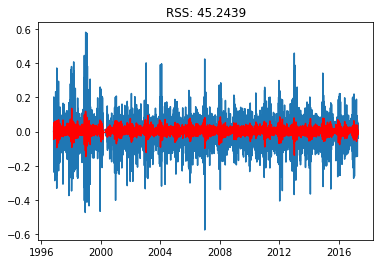

In [42]:
model1=ARIMA(ts_log , order=(0,1,2))#MA MODEL
results1=model1.fit(disp=1)
plt.plot(ts_log_diff)
plt.plot(results1.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results1.fittedvalues-ts_log_diff)**2))
print('plotting ma model')